In [1]:
import torch
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

# This line gets the current notebook's directory
notebook_dir = %pwd

# Assuming your 'src' folder is in the parent directory of the notebook directory
project_root = os.path.dirname(notebook_dir)
src_path = os.path.join(project_root, "src")

# Adding the 'src' directory to sys.path
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image, CollateFunction

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_train"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_test"

train_dataset = SongDataSet_Image(train_dir, num_classes=21)
test_dataset = SongDataSet_Image(test_dir, num_classes=21)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

FileNotFoundError: [Errno 2] No such file or directory: '/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_train'

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


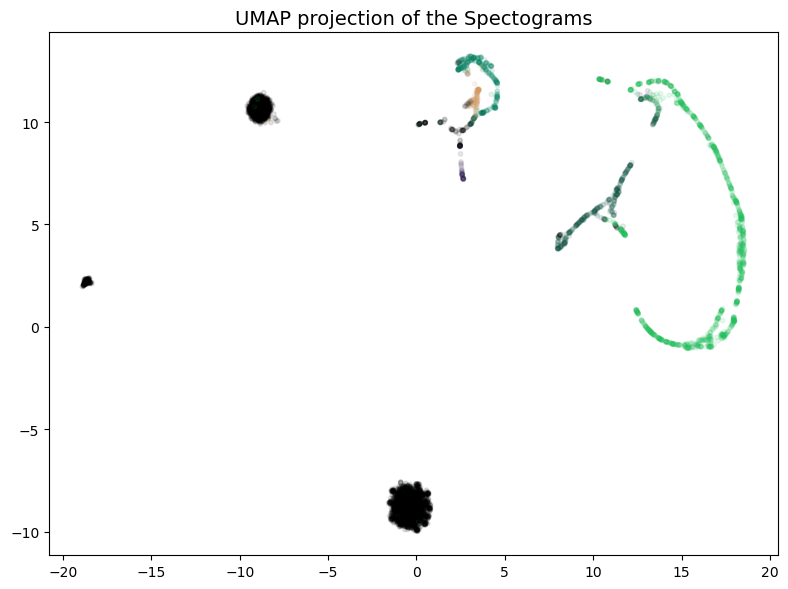

In [3]:
import pickle 
import umap

reductions_dims = 2
plot_figure = True 
data_set_size = int(5e3)

list_of_data = []
list_of_ground_truth = []

for i,  (data, ground_truth_label) in enumerate(test_loader):
    # remove channel dim (used for conv)
    data = data[:,0,:,:]
    data = data.permute(0,2,1)
    ground_truth_label = ground_truth_label.argmax(-1)
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    ground_truth_label = ground_truth_label.reshape(-1,1)
    data = data.reshape(-1,1 * 196)
    list_of_data.append(data)
    list_of_ground_truth.append(ground_truth_label)

# Concatenate the lists
list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# # Randomly sample 10,000 points because large UMAPing large amounts of data is bug prone and 
# sample_indices = np.random.choice(list_of_data.shape[0], 5000, replace=False)
list_of_data_sampled = list_of_data[:data_set_size]
list_of_ground_truth_sampled = list_of_ground_truth[:data_set_size]

# color stuff #
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/category_colors_llb3.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

colors_for_points = []
for label_row in list_of_ground_truth_sampled:
    if label_row.ndim > 0:
        # If label_row is iterable (more than one dimension)
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        # If label_row is a single integer (one dimension)
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)


# UMAP reduction, eucledian looks the best 
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.05, n_components=reductions_dims, metric='cosine')
embedding_outputs = reducer.fit_transform(list_of_data_sampled)

# Plotting (if conditions are met)
if reductions_dims == 2 and plot_figure == True:
    # Create the plot
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=10, c=colors_for_points, alpha=.1)
    plt.title('UMAP projection of the Spectograms', fontsize=14)
    plt.tight_layout()
    plt.show()

In [4]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="umap", model=reducer, freeze_layers=True, layer_num=-1, layer_id="feed_forward_output_relu", classifier_dims=2)
classifier_model = classifier_model.to(device)

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Batch 1: FER = 96.25%, Train Loss = 6.6706, Val Loss = 8.9864
Batch 2: FER = 95.20%, Train Loss = 7.9362, Val Loss = 8.8456
Batch 3: FER = 99.80%, Train Loss = 9.5052, Val Loss = 9.4059
Batch 4: FER = 95.90%, Train Loss = 7.7416, Val Loss = 8.7580
Batch 5: FER = 97.00%, Train Loss = 9.0890, Val Loss = 7.7676
Batch 6: FER = 88.25%, Train Loss = 10.1342, Val Loss = 7.7003
Batch 7: FER = 96.80%, Train Loss = 7.0732, Val Loss = 9.1000
Batch 8: FER = 95.45%, Train Loss = 9.5141, Val Loss = 7.6129
Batch 9: FER = 84.40%, Train Loss = 10.1901, Val Loss = 7.0345
Batch 10: FER = 93.65%, Train Loss = 6.1975, Val Loss = 7.8362
Batch 11: FER = 98.40%, Train Loss = 9.2687, Val Loss = 7.5312
Batch 12: FER = 90.40%, Train Loss = 6.7991, Val Loss = 7.4562
Batch 13: FER = 98.70%, Train Loss = 7.9478, Val Loss = 8.3923
Batch 14: FER = 75.95%, Train Loss = 7.6118, Val Loss = 6.6081
Batch 15: FER = 97.45%, Train Loss = 6.1065, Val Loss = 6.5226
Batch 16: FER = 99.15%, Train Loss = 7.5179, Val Loss = 7.8492

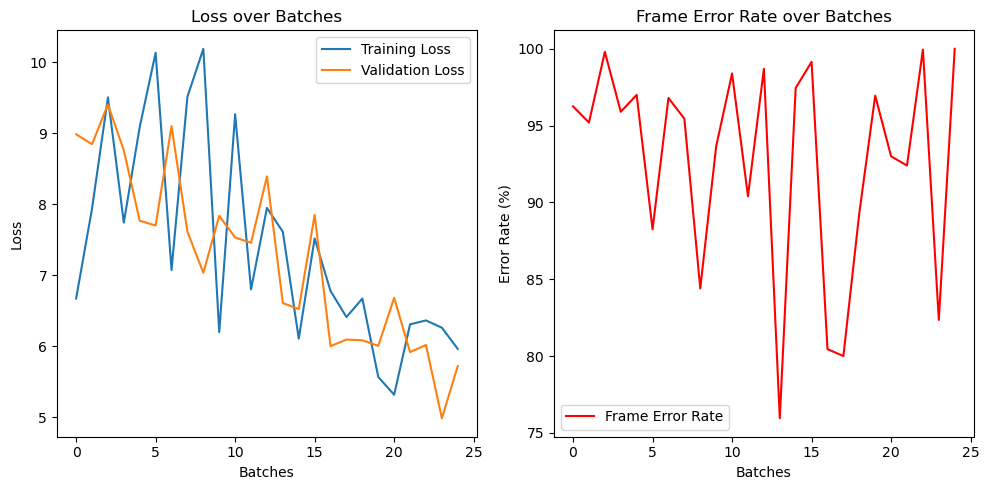

In [5]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=1, desired_total_batches=25, patience=8)
trainer.train()

In [6]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, f'{project_root}/results/umap_results_with_{reductions_dims}_dims')

Evaluating:   4%|▎         | 21/566 [00:19<08:49,  1.03batch/s]

SystemError: CPUDispatcher(<function NNDescent._init_search_function.<locals>.search_closure at 0x7efeb1a41e40>) returned a result with an exception set